# Notes:
- Check for coutry and agent if we have to drop them

In [30]:
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score, f1_score, balanced_accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from copy import deepcopy
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer,RobustScaler,QuantileTransformer
from sklearn.pipeline import Pipeline

In [31]:
df = pd.read_csv('C:/Users/stavr/Documents/BigBlueDataAcademy_DSBPT/Booking_cancelation/Data/hotel_bookings.csv')
df_cancels = deepcopy(df)
df_cancels.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [32]:
df_cancels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [33]:
df_cancels.isna().sum().sum()

129425

In [34]:
df_cancels.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [35]:
categories = df_cancels.select_dtypes('object')

In [36]:
columns = categories.columns.tolist()

for i in columns:
    print(i,categories[i].dtype,categories[i].nunique())
    print(categories[i].unique())
    print(50*'-')

hotel object 2
['Resort Hotel' 'City Hotel']
--------------------------------------------------
arrival_date_month object 12
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
--------------------------------------------------
meal object 5
['BB' 'FB' 'HB' 'SC' 'Undefined']
--------------------------------------------------
country object 177
['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH'

In [37]:
numeric_col = df_cancels.drop(columns=categories).columns.tolist()
for i in numeric_col:
    print(i,df_cancels[i].dtype,df_cancels[i].nunique())
    print(df_cancels[i].unique())
    print(50*'-')

is_canceled int64 2
[0 1]
--------------------------------------------------
lead_time int64 479
[342 737   7  13  14   0   9  85  75  23  35  68  18  37  12  72 127  78
  48  60  77  99 118  95  96  69  45  40  15  36  43  70  16 107  47 113
  90  50  93  76   3   1  10   5  17  51  71  63  62 101   2  81 368 364
 324  79  21 109 102   4  98  92  26  73 115  86  52  29  30  33  32   8
 100  44  80  97  64  39  34  27  82  94 110 111  84  66 104  28 258 112
  65  67  55  88  54 292  83 105 280 394  24 103 366 249  22  91  11 108
 106  31  87  41 304 117  59  53  58 116  42 321  38  56  49 317   6  57
  19  25 315 123  46  89  61 312 299 130  74 298 119  20 286 136 129 124
 327 131 460 140 114 139 122 137 126 120 128 135 150 143 151 132 125 157
 147 138 156 164 346 159 160 161 333 381 149 154 297 163 314 155 323 340
 356 142 328 144 336 248 302 175 344 382 146 170 166 338 167 310 148 165
 172 171 145 121 178 305 173 152 354 347 158 185 349 183 352 177 200 192
 361 207 174 330 134 350 33

In [38]:
# Columns to drop due to data leakage:
to_drop = ['reservation_status_date',
         'reservation_status',
         'assigned_room_type',
         'arrival_date_year',
         'company',
         'agent',
         'country']

In [39]:
# drop columns
df_cancels.drop(columns=to_drop,inplace=True)

# Manual Imputation

In [40]:
df_cancels['children'] = df_cancels['children'].fillna(0)

# Correlation Analysis

C:\Users\stavr\AppData\Local\Temp\ipykernel_25436\2905076439.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_cancels.corr(),annot=True,fmt='.2g')


<AxesSubplot:>

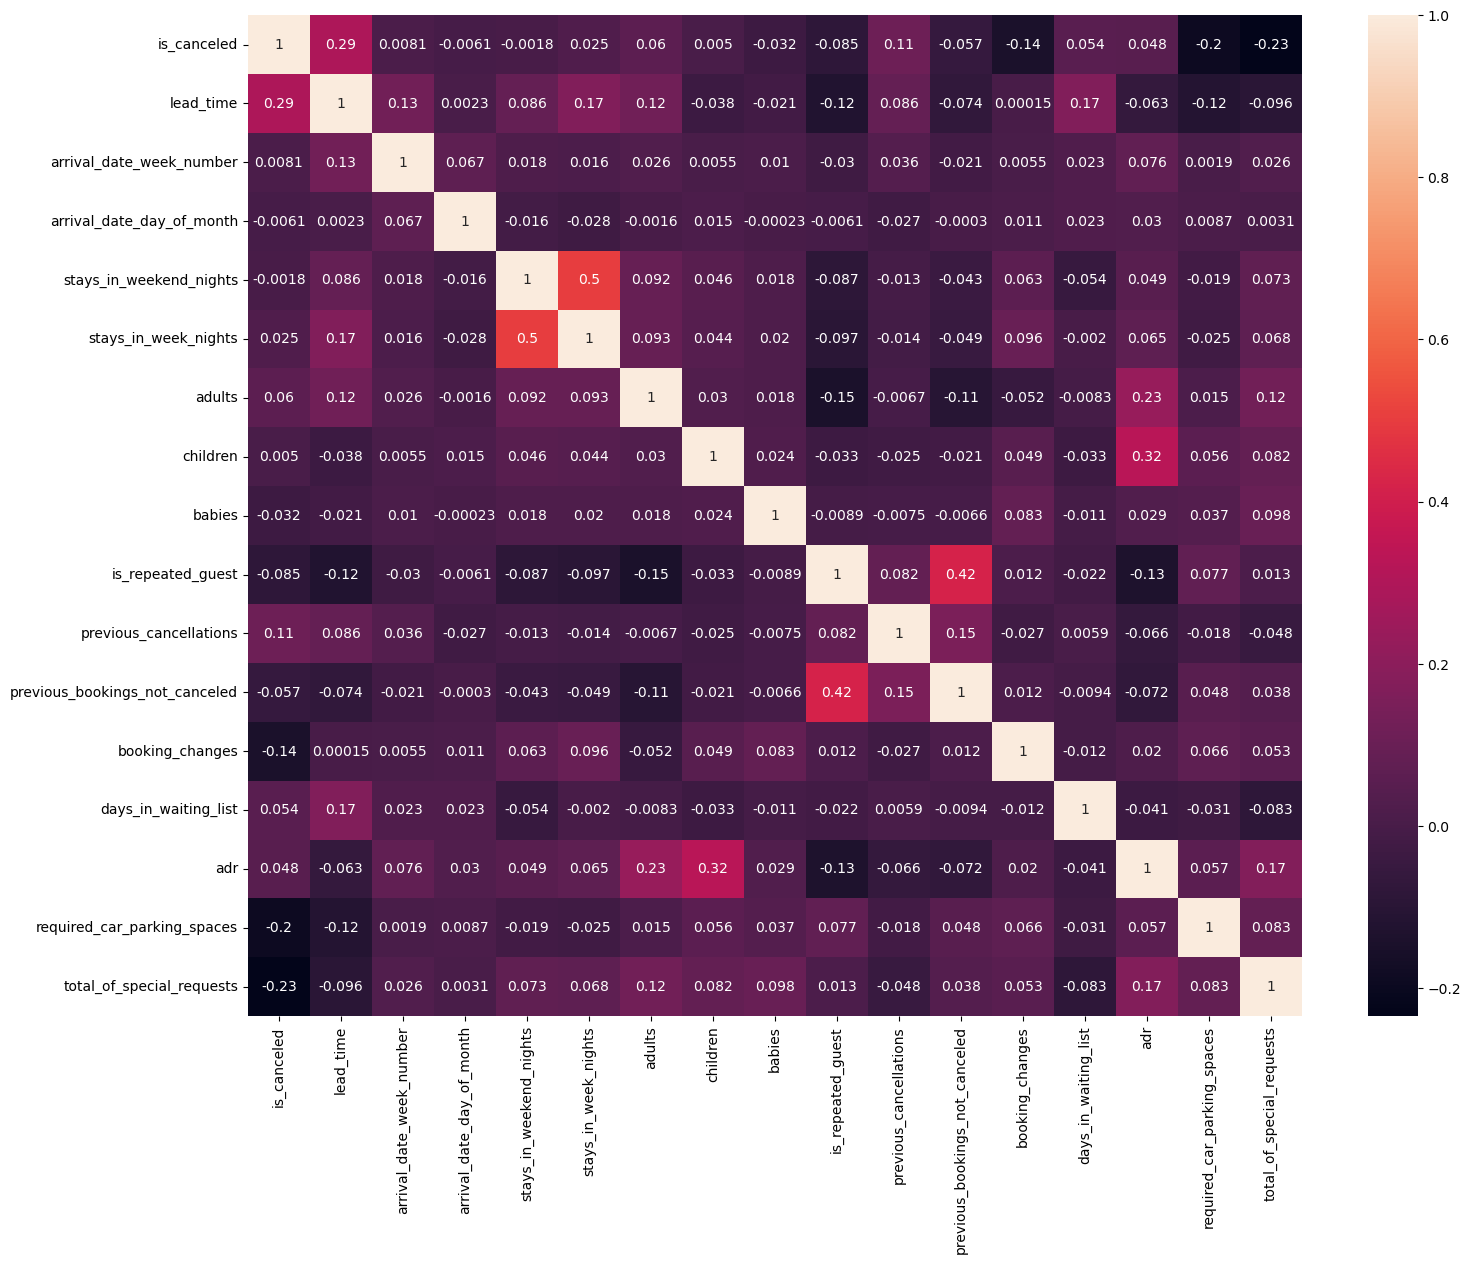

In [41]:
plt.figure(figsize=(17,13))
sns.heatmap(df_cancels.corr(),annot=True,fmt='.2g')

# Noisy Data

In [42]:
df_cancels.describe().round(2).T

# Not make sence data:
# Adults --> It not makes sence to be zero as only adults can book a room
# adr --> average daily rate is not make sence to be negative
# check stays_in_weekend_night & stays_in_week_nights to not be zero simutanuslly

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.37,0.48,0.00,0.00,0.00,1.0,1.0
lead_time,119390.0,104.01,106.86,0.00,18.00,69.00,160.0,737.0
arrival_date_week_number,119390.0,27.17,13.61,1.00,16.00,28.00,38.0,53.0
arrival_date_day_of_month,119390.0,15.80,8.78,1.00,8.00,16.00,23.0,31.0
stays_in_weekend_nights,119390.0,0.93,1.00,0.00,0.00,1.00,2.0,19.0
stays_in_week_nights,119390.0,2.50,1.91,0.00,1.00,2.00,3.0,50.0
adults,119390.0,1.86,0.58,0.00,2.00,2.00,2.0,55.0
children,119390.0,0.10,0.40,0.00,0.00,0.00,0.0,10.0
babies,119390.0,0.01,0.10,0.00,0.00,0.00,0.0,10.0
is_repeated_guest,119390.0,0.03,0.18,0.00,0.00,0.00,0.0,1.0


In [43]:
df_cancels.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,July,27,1,0,0,2,0.0,0,BB,Direct,Direct,0,0,0,C,3,No Deposit,0,Transient,0.0,0,0
1,Resort Hotel,0,737,July,27,1,0,0,2,0.0,0,BB,Direct,Direct,0,0,0,C,4,No Deposit,0,Transient,0.0,0,0
2,Resort Hotel,0,7,July,27,1,0,1,1,0.0,0,BB,Direct,Direct,0,0,0,A,0,No Deposit,0,Transient,75.0,0,0
3,Resort Hotel,0,13,July,27,1,0,1,1,0.0,0,BB,Corporate,Corporate,0,0,0,A,0,No Deposit,0,Transient,75.0,0,0
4,Resort Hotel,0,14,July,27,1,0,2,2,0.0,0,BB,Online TA,TA/TO,0,0,0,A,0,No Deposit,0,Transient,98.0,0,1


### Adults

In [44]:
df_cancels['adults'].value_counts()

2     89680
1     23027
3      6202
0       403
4        62
26        5
27        2
20        2
5         2
40        1
50        1
55        1
6         1
10        1
Name: adults, dtype: int64

In [45]:
df_cancels['adults'].value_counts()[0]

403

<AxesSubplot:xlabel='adults', ylabel='Count'>

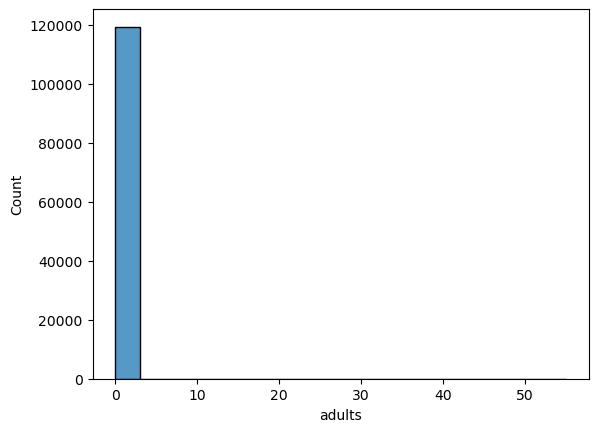

In [46]:
sns.histplot(df_cancels['adults'])

<AxesSubplot:>

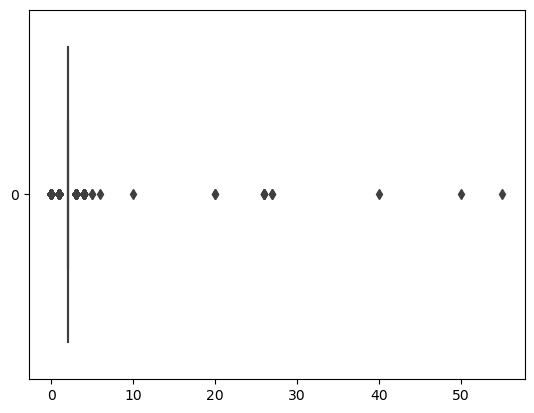

In [47]:
sns.boxplot(df_cancels['adults'],orient='h',showfliers=True)

In [48]:
df_cancels = df_cancels.loc[(df_cancels['adults'] > 0)&(df_cancels['adults'] < 5)]

In [49]:
df_cancels.shape

(118971, 25)

### Children

In [50]:
df_cancels['children'].value_counts()

0.0     110604
1.0       4857
2.0       3444
3.0         65
10.0         1
Name: children, dtype: int64

In [51]:
df_cancels = df_cancels.loc[(df_cancels['children'] < 4 )]

In [52]:
df_cancels.shape

(118970, 25)

### babies

In [53]:
df_cancels['babies'].value_counts()

0     118056
1        897
2         15
10         1
9          1
Name: babies, dtype: int64

In [54]:
df_cancels = df_cancels.loc[(df_cancels['babies'] < 4 )]

In [55]:
df_cancels.shape

(118968, 25)

### adr

In [56]:
df_cancels['adr'].describe().round()

count    118968.0
mean        102.0
std          50.0
min          -6.0
25%          70.0
50%          95.0
75%         126.0
max        5400.0
Name: adr, dtype: float64

<AxesSubplot:>

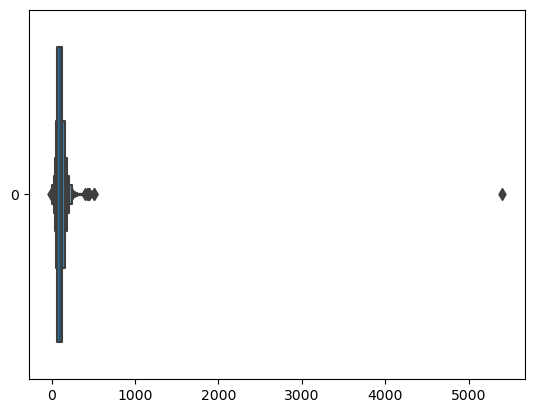

In [57]:
sns.boxenplot(df_cancels['adr'],orient='h',showfliers=True)

In [58]:
df_cancels = df_cancels.loc[(df_cancels['adr']>0) & (df_cancels['adr']<1000)]

In [59]:
df_cancels.shape

(117178, 25)

### days_in_waiting_list

In [60]:
df_cancels['days_in_waiting_list']

2         0
3         0
4         0
5         0
6         0
         ..
119385    0
119386    0
119387    0
119388    0
119389    0
Name: days_in_waiting_list, Length: 117178, dtype: int64

In [61]:
df_cancels['days_in_waiting_list'].value_counts()

0      113512
39        227
58        164
44        141
31        127
        ...  
121         1
165         1
37          1
193         1
36          1
Name: days_in_waiting_list, Length: 127, dtype: int64

<AxesSubplot:xlabel='days_in_waiting_list', ylabel='Count'>

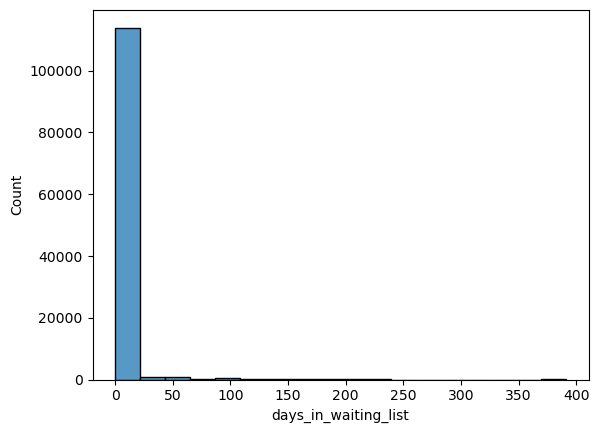

In [62]:
sns.histplot(df_cancels['days_in_waiting_list'])

In [63]:
df_cancels = df_cancels.loc[df_cancels['days_in_waiting_list'] < 150]

In [64]:
df_cancels.shape

(116733, 25)

### lead_time

<AxesSubplot:xlabel='lead_time', ylabel='Count'>

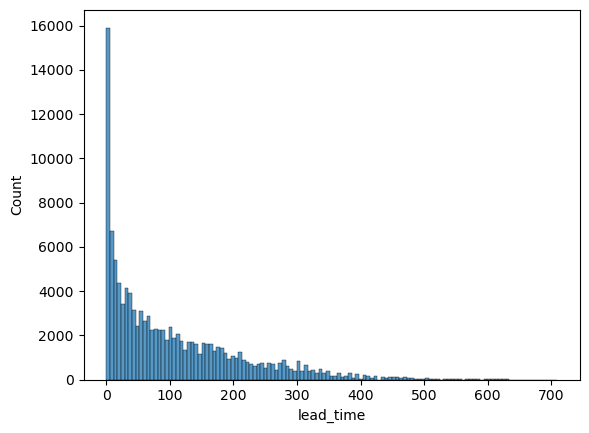

In [65]:
sns.histplot(df_cancels['lead_time'])

In [70]:
df_cancels=df_cancels.loc[df_cancels['lead_time'] < 400]

In [71]:
df_cancels.shape

(114768, 25)

# Outliers

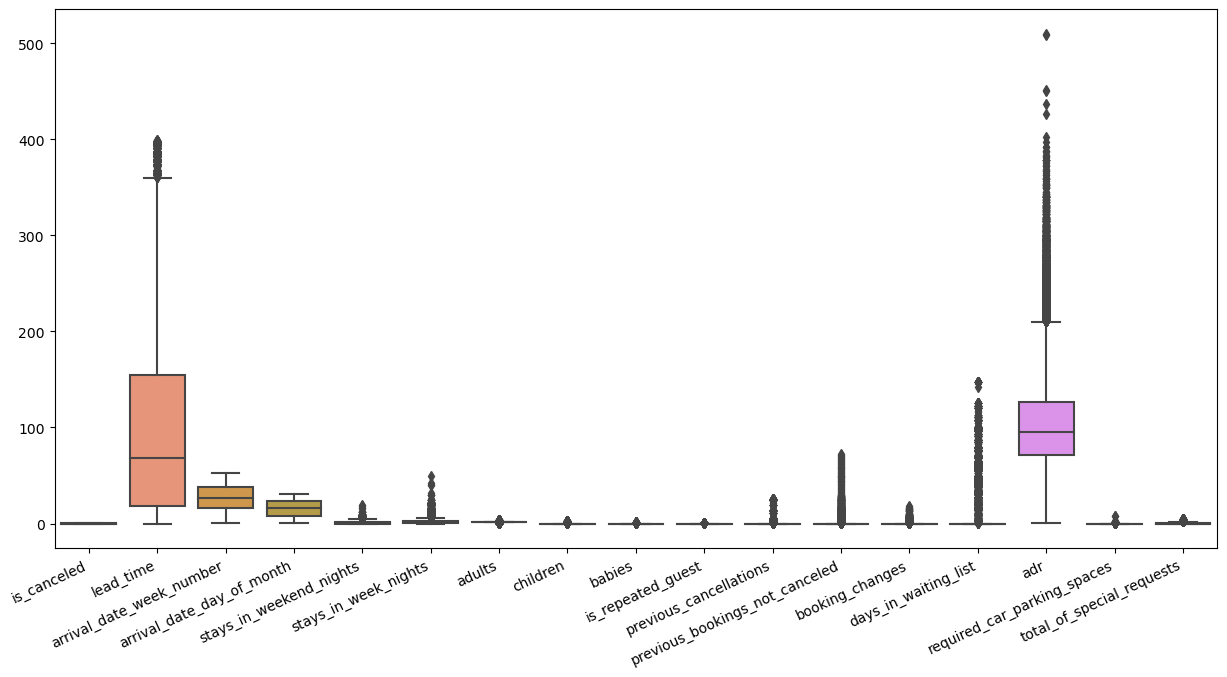

In [72]:
plt.figure(figsize=(15,7))
sns.boxplot(df_cancels)
plt.xticks(rotation=25,ha='right',va='top');

In [74]:
df_cancels.shape

(114768, 25)

# Dummies 

In [81]:
dummy_columns = df_cancels.select_dtypes('object').columns.tolist()
dummy_columns.remove('arrival_date_month')
dummy_columns

['hotel',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type']

In [82]:
df_cancels = pd.get_dummies(df_cancels,columns=dummy_columns,drop_first=True)

In [87]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_cancels['arrival_date_month'] = df['arrival_date_month'].apply(lambda x: months.index(x) + 1)
df_cancels['arrival_date_month'].unique()

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6], dtype=int64)

In [88]:
df_cancels

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
2,0,7,7,27,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,13,7,27,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,14,7,27,1,0,2,2,0.0,0,0,0,0,0,0,98.00,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,14,7,27,1,0,2,2,0.0,0,0,0,0,0,0,98.00,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,7,27,1,0,2,2,0.0,0,0,0,0,0,0,107.00,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,8,35,30,2,5,2,0.0,0,0,0,0,0,0,96.14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
119386,0,102,8,35,31,2,5,3,0.0,0,0,0,0,0,0,225.43,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
119387,0,34,8,35,31,2,5,2,0.0,0,0,0,0,0,0,157.71,0,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
119388,0,109,8,35,31,2,5,2,0.0,0,0,0,0,0,0,104.40,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# Correlation Analysis

<AxesSubplot:>

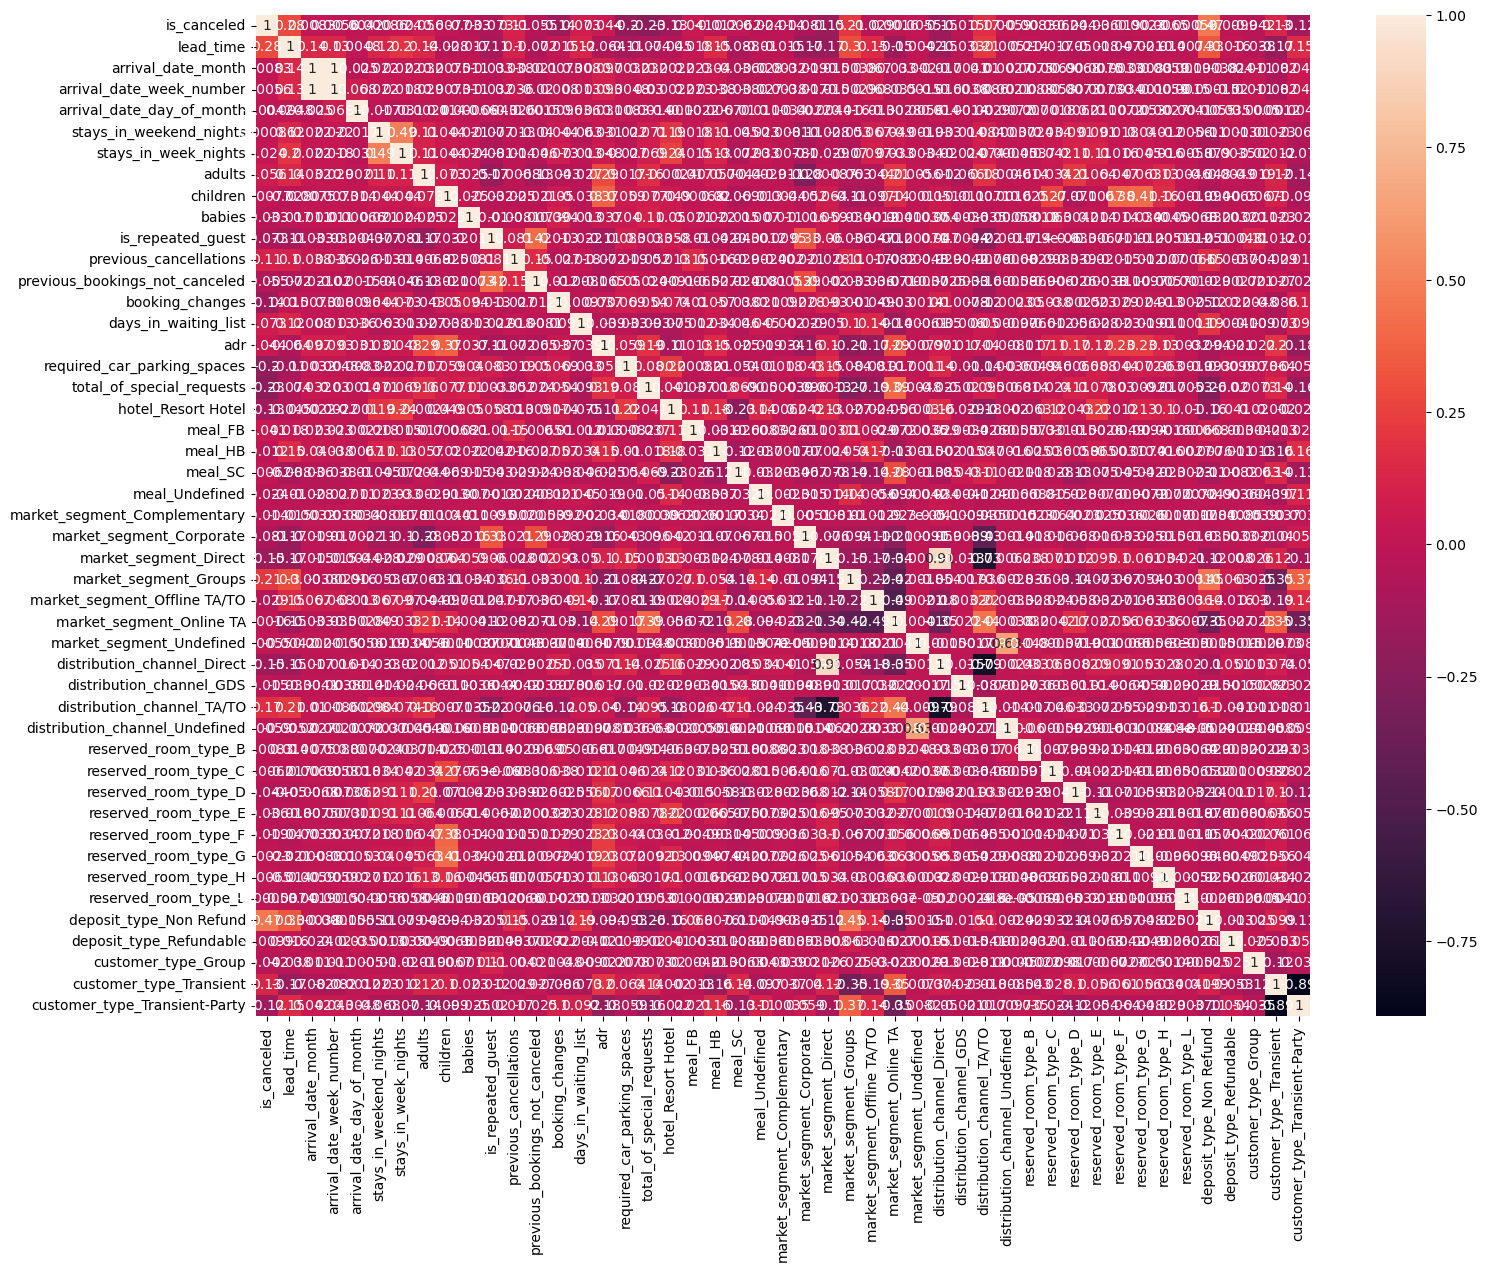

In [92]:
plt.figure(figsize=(17,13))
sns.heatmap(df_cancels.corr(),annot=True,fmt='.2g')

In [94]:
# Set a correlation threshold
corr_thresh = 0.85

df_corr = df_cancels.corr()

# Select upper triangle of correlation matrix
upper_triangle = df_corr.where(np.triu(np.ones(df_corr.shape),k=1).astype(bool)) # the .astype(bool) is the same thing as :
                                                                                 # np.triu(np.ones(df_corr.shape),k=1)==1   or   np.triu(np.ones(df_corr.shape),k=1)==True
# Find features with correlation greater than the set threshold
to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > corr_thresh)]
to_drop

['arrival_date_week_number', 'distribution_channel_Direct']

In [97]:
df_cancels.drop(columns = ['arrival_date_month','distribution_channel_Direct'],inplace=True)

In [98]:
df_cancels.to_csv('C:/Users/stavr/Documents/BigBlueDataAcademy_DSBPT/Booking_cancelation/Data/final_df.csv',index=False)